<a href="https://colab.research.google.com/github/JeanJulesBigeard/Getting-started-with-OpenCV/blob/master/Text_Detection/4_Text_Detection_EAST.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# <font color="blue">Text Detection using EAST</font>
In this notebook, we will go over the EAST Text Detector. We will use OpenCV to load the model and perform detections.

In [0]:
import cv2
import glob
import math
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
!pip install keras-ocr > /dev/null
from keras_ocr.tools import warpBox

## <font color="blue">1. Download EAST model </font>

In [0]:
!wget https://www.dropbox.com/s/axmr969oaz2km3e/frozen_east_text_detection.tar.gz?dl=0 -O frozen_east_text_detection.tar.gz --quiet
!tar -xvzf frozen_east_text_detection.tar.gz 

frozen_east_text_detection.pb


# <font color="blue">2. Specify parameters for detection</font>

There are two outputs of the network. One specifies the geometry of the Text-box and the other specifies the confidence score of the detected box. These are given by the layers :

- feature_fusion/concat_3
- feature_fusion/Conv_7/Sigmoid

We will add them to a list and pass this list to the network while generating the output so that the code knows which nodes to evaluate.

Apart from this, we need to specify the network input size and thresholds for detection.

In [0]:
model = "frozen_east_text_detection.pb"
net = cv2.dnn.readNet(model)
outputLayers = []
outputLayers.append("feature_fusion/Conv_7/Sigmoid")
outputLayers.append("feature_fusion/concat_3")
inpWidth = 640
inpHeight = 640
confThreshold = 0.7
nmsThreshold = 0.4

# <font color="blue">3. Utility function for getting Rotated Rectangles</font>
The output of the network is in the form of rotated rectangles. Strangely,OpenCV has a function for NMS on rotated rectangles but no function to generate rotated rectangles in Python. This function takes in the bounding boxes from the network output and creates rotated rectangles which can be fed to the NMS function.

In [0]:
############ Utility functions ############
def decode(scores, geometry, scoreThresh):
    detections = []
    confidences = []

    ############ CHECK DIMENSIONS AND SHAPES OF geometry AND scores ############
    assert len(scores.shape) == 4, "Incorrect dimensions of scores"
    assert len(geometry.shape) == 4, "Incorrect dimensions of geometry"
    assert scores.shape[0] == 1, "Invalid dimensions of scores"
    assert geometry.shape[0] == 1, "Invalid dimensions of geometry"
    assert scores.shape[1] == 1, "Invalid dimensions of scores"
    assert geometry.shape[1] == 5, "Invalid dimensions of geometry"
    assert scores.shape[2] == geometry.shape[2], "Invalid dimensions of scores and geometry"
    assert scores.shape[3] == geometry.shape[3], "Invalid dimensions of scores and geometry"
    height = scores.shape[2]
    width = scores.shape[3]
    for y in range(0, height):

        # Extract data from scores
        scoresData = scores[0][0][y]
        x0_data = geometry[0][0][y]
        x1_data = geometry[0][1][y]
        x2_data = geometry[0][2][y]
        x3_data = geometry[0][3][y]
        anglesData = geometry[0][4][y]
        for x in range(0, width):
            score = scoresData[x]

            # If score is lower than threshold score, move to next x
            if(score < scoreThresh):
                continue

            # Calculate offset
            offsetX = x * 4.0
            offsetY = y * 4.0
            angle = anglesData[x]

            # Calculate cos and sin of angle
            cosA = math.cos(angle)
            sinA = math.sin(angle)
            h = x0_data[x] + x2_data[x]
            w = x1_data[x] + x3_data[x]

            # Calculate offset
            offset = ([offsetX + cosA * x1_data[x] + sinA * x2_data[x], offsetY - sinA * x1_data[x] + cosA * x2_data[x]])

            # Find points for rectangle
            p1 = (-sinA * h + offset[0], -cosA * h + offset[1])
            p3 = (-cosA * w + offset[0],  sinA * w + offset[1])
            center = (0.5*(p1[0]+p3[0]), 0.5*(p1[1]+p3[1]))
            detections.append((center, (w,h), -1*angle * 180.0 / math.pi))
            confidences.append(float(score))

    # Return detections and confidences
    return [detections, confidences]

# <font color="blue">4. Perform Text Detection</font>
For performing detection, we need to pass the image through the network and decode the output.

First, we need to create a 4-D input blob for feeding the image to the network. This is done using the **`blobFromImage`** function.

There are a few parameters we need to specify to this function. They are as follows :

1. The first argument is the image itself
1. The second argument specifies the scaling of each pixel value. In this case, it is not required. Thus we keep it as 1.
1. The default input to the network is `320×320`. So, we need to specify this while creating the blob. We will use `640x640`.
1. We also specify the mean that should be subtracted from each image since this was used while training the model. The mean used is (123.68, 116.78, 103.94).
1. The next argument is whether we want to swap the R and B channels. This is required since OpenCV uses BGR format and Tensorflow uses RGB format.
1. The last argument is whether we want to crop the image and take the center crop. We specify False in this case.

Once we have the output of the network, we need to use the decode function to decode the positions of the text boxes along with their orientation. We might get many candidates for a text box. Thus, we need to filter out the best looking text-boxes from the lot. This is done using Non-Maximum Suppression

Finally, we warp the boxes to fit into a rectangle so that the text is aligned. This is done using the warpBox function available in the keras-ocr package ( we will discuss more on this later ).

In [0]:
def eastTextDetection(imageName, saveCrops = False):
  
  image = cv2.imread(imageName)
  imageOut = image.copy()
  # Get Height and width of the image.
  height_ = image.shape[0]
  width_ = image.shape[1]
  
  # Get ratio by which the image is resized for using in the network
  rW = width_ / float(inpWidth)
  rH = height_ / float(inpHeight)

  # Create a blob and assign the image to the blob
  blob = cv2.dnn.blobFromImage(image, 1.0, (inpWidth, inpHeight), (123.68, 116.78, 103.94), True, False)
  net.setInput(blob)

  # Get the output using by passing the image through the network
  output = net.forward(outputLayers)
  scores = output[0]
  geometry = output[1]

  # Get rotated rectangles using the decode function described above
  [boxes, confidences] = decode(scores, geometry, confThreshold)  
  indices = cv2.dnn.NMSBoxesRotated(boxes, confidences, confThreshold,nmsThreshold)

  cropped_warped_all = []
  for i,idx in enumerate(indices):
    # get 4 corners of the rotated rect
    vertices = cv2.boxPoints(boxes[idx[0]])

    # scale the bounding box coordinates based on the respective ratios
    for j in range(4):
      vertices[j][0] *= rW
      vertices[j][1] *= rH
    
    pts = np.array(vertices,dtype=int)

    # Align the cropped boxes using perspective transform
    cropped_warped = warpBox(image, pts)
    cropped_warped_all.append(cropped_warped)
    
    # Save cropped text boxes if required
    if saveCrops:
      cv2.imwrite("crop{}_{}".format(i,imageName), cropped_warped)
    
    # Annotate the boxes on the image
    for j in range(4):
      p1 = (vertices[j][0], vertices[j][1])
      p2 = (vertices[(j + 1) % 4][0], vertices[(j + 1) % 4][1])
      cv2.line(imageOut, p1, p2, (0, 255, 0), 2, cv2.LINE_AA)
    
  return imageOut, cropped_warped_all

# <font color="blue">5. Download Images</font>

In [0]:
!wget https://www.dropbox.com/s/xz24vxrp4uvvnri/license_plate.jpg?dl=0 -O demo1.jpg --quiet
!wget https://www.dropbox.com/s/uwlnxiihqgni57o/streetsign1.jpg?dl=0 -O demo2.jpg --quiet
!wget https://www.dropbox.com/s/dbkag5gsicxqoqg/streetsign2.jpg?dl=0 -O demo3.jpg --quiet

Get all images starting with demo and create a list. We will perform detection on this list of images.

In [0]:
imageNames = glob.glob("demo*.jpg")

# <font color="blue">6. Display Outputs</font>
We will display the annotated output image as well as 4 cropped images.

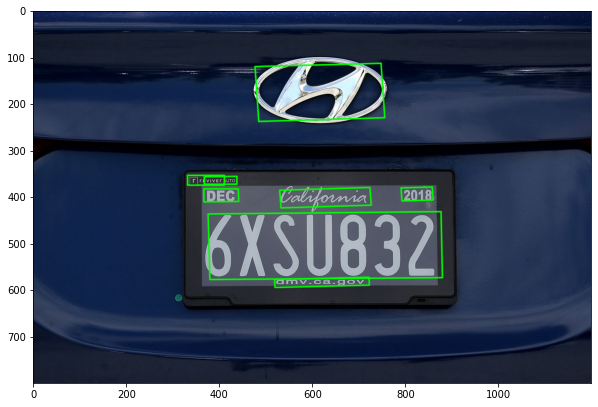

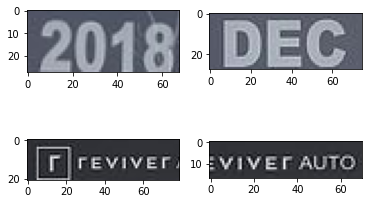

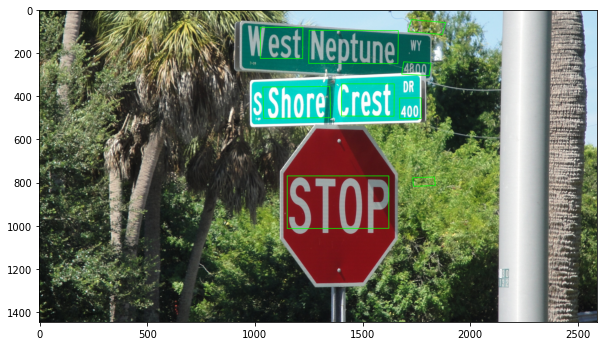

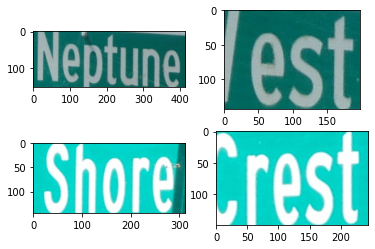

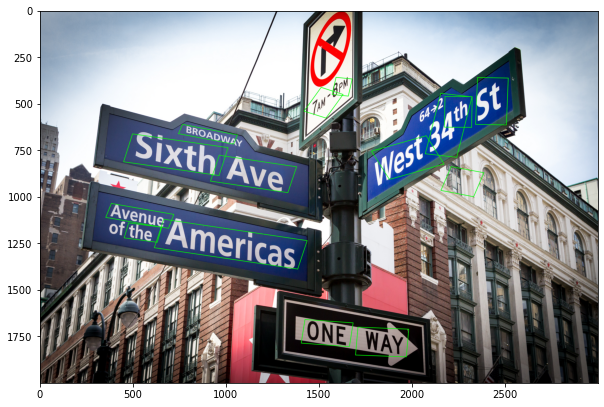

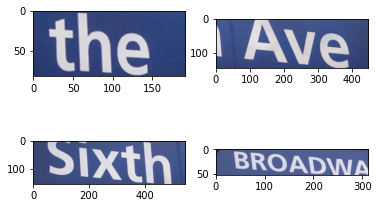

In [0]:
# Plot the predictions
for imageName in imageNames:
  imgOut,warped = eastTextDetection(imageName,saveCrops=True)
  plt.figure(figsize=[10,10])
  plt.imshow(imgOut[:,:,::-1])
  plt.show()
  for i in range(1,5):
    plt.subplot(2,2,i)
    plt.imshow(warped[i][:,:,::-1])
  plt.show()

It makes a few mistakes in some cases. We will learn about a more robust algorithm called **`CRAFT`** in the next notebook.